In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler


from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import torch
import torch.nn as nn

import xgboost as xgb


%matplotlib inline

## Loading dataset

In [4]:
x_train = pd.read_csv('../Data/dengue_features_train.csv', index_col= [0, 1, 2])
y_train = pd.read_csv('../Data/dengue_labels_train.csv', index_col= [0, 1, 2])
x_test = pd.read_csv('../Data/dengue_features_test.csv', index_col= [0, 1, 2])

## Data preprocessing

### Check shape of data

In [5]:
print('x_train: ',{x_train.shape})
x_train.head()

x_train:  {(1456, 21)}


week_start_date   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
city year weekofyear                                                           
sj   1990 18              1990-04-30  0.122600  0.103725  0.198483  0.177617   
          19              1990-05-07  0.169900  0.142175  0.162357  0.155486   
          20              1990-05-14  0.032250  0.172967  0.157200  0.170843   
          21              1990-05-21  0.128633  0.245067  0.227557  0.235886   
          22              1990-05-28  0.196200  0.262200  0.251200  0.247340   

                      precipitation_amt_mm  reanalysis_air_temp_k  \
city year weekofyear                                                
sj   1990 18                         12.42             297.572857   
          19                         22.82             298.211429   
          20                         34.54             298.781429   
          21                         15.36             298.987143   
          22                          7.52             299.518571   

                      reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
city year weekofyear                                                       
sj   1990 18                     297.742857                   292.414286   
          19                     298.442857                   293.951429   
          20                     298.878571                   295.434286   
          21                     299.228571                   295.310000   
          22                     299.664286                   295.821429   

                      reanalysis_max_air_temp_k  ...  \
city year weekofyear                             ...   
sj   1990 18                              299.8  ...   
          19                              300.9  ...   
          20                              300.5  ...   
          21                              301.4  ...   
          22                              301.9  ...   

                      reanalysis_precip_amt_kg_per_m2  \
city year weekofyear                                    
sj   1990 18                                    32.00   
          19                                    17.94   
          20                                    26.10   
          21                                    13.90   
          22                                    12.20   

                      reanalysis_relative_humidity_percent  \
city year weekofyear                                         
sj   1990 18                                     73.365714   
          19                                     77.368571   
          20                                     82.052857   
          21                                     80.337143   
          22                                     80.460000   

                      reanalysis_sat_precip_amt_mm  \
city year weekofyear                                 
sj   1990 18                                 12.42   
          19                                 22.82   
          20                                 34.54   
          21                                 15.36   
          22                                  7.52   

                      reanalysis_specific_humidity_g_per_kg  \
city year weekofyear                                          
sj   1990 18                                      14.012857   
          19                                      15.372857   
          20                                      16.848571   
          21                                      16.672857   
          22                                      17.210000   

                      reanalysis_tdtr_k  station_avg_temp_c  \
city year weekofyear                                          
sj   1990 18                   2.628571           25.442857   
          19                   2.371429           26.714286   
          20                   2.300000           26.714286   
          21                   2.428571           27.471429   
          22    

In [6]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1456 entries, ('sj', np.int64(1990), np.int64(18)) to ('iq', np.int64(2010), np.int64(25))
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   week_start_date                        1456 non-null   object 
 1   ndvi_ne                                1262 non-null   float64
 2   ndvi_nw                                1404 non-null   float64
 3   ndvi_se                                1434 non-null   float64
 4   ndvi_sw                                1434 non-null   float64
 5   precipitation_amt_mm                   1443 non-null   float64
 6   reanalysis_air_temp_k                  1446 non-null   float64
 7   reanalysis_avg_temp_k                  1446 non-null   float64
 8   reanalysis_dew_point_temp_k            1446 non-null   float64
 9   reanalysis_max_air_temp_k              1446 non-null   float64
 10  reana

In [7]:
print('y_train: ',{y_train.shape})
y_train.head()

y_train:  {(1456, 1)}


total_cases
city year weekofyear             
sj   1990 18                    4
          19                    5
          20                    4
          21                    3
          22                    6

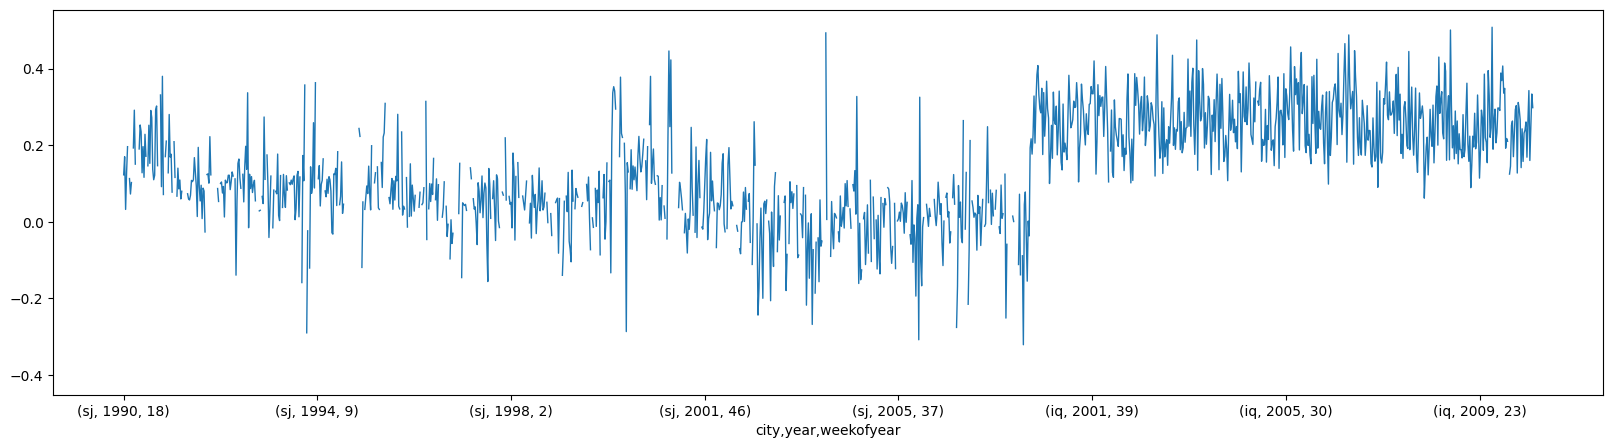

In [8]:
plt.figure(figsize = (20, 5))
(x_train
     .ndvi_ne
     .plot
     .line(lw = 1))

plt.show()

### Seperate data for SJ and IQ

In [9]:
sj_x_train = x_train.loc['sj'].copy()
iq_x_train = x_train.loc['iq'].copy()

sj_y_train = y_train.loc['sj'].copy()
iq_y_train = y_train.loc['iq'].copy()  

sj_x_test = x_test.loc['sj'].copy()
iq_x_test = x_test.loc['iq'].copy()



In [10]:
sj_x_train.ffill(inplace=True)
sj_x_test.ffill(inplace=True)

iq_x_train.ffill(inplace=True)
iq_x_test.ffill(inplace=True)

We drop the week_start_date column for now.

In [11]:
sj_x_train.drop('week_start_date', axis = 1, inplace = True)
                       
iq_x_train.drop('week_start_date', axis = 1, inplace = True)

### Correlation heatmaps

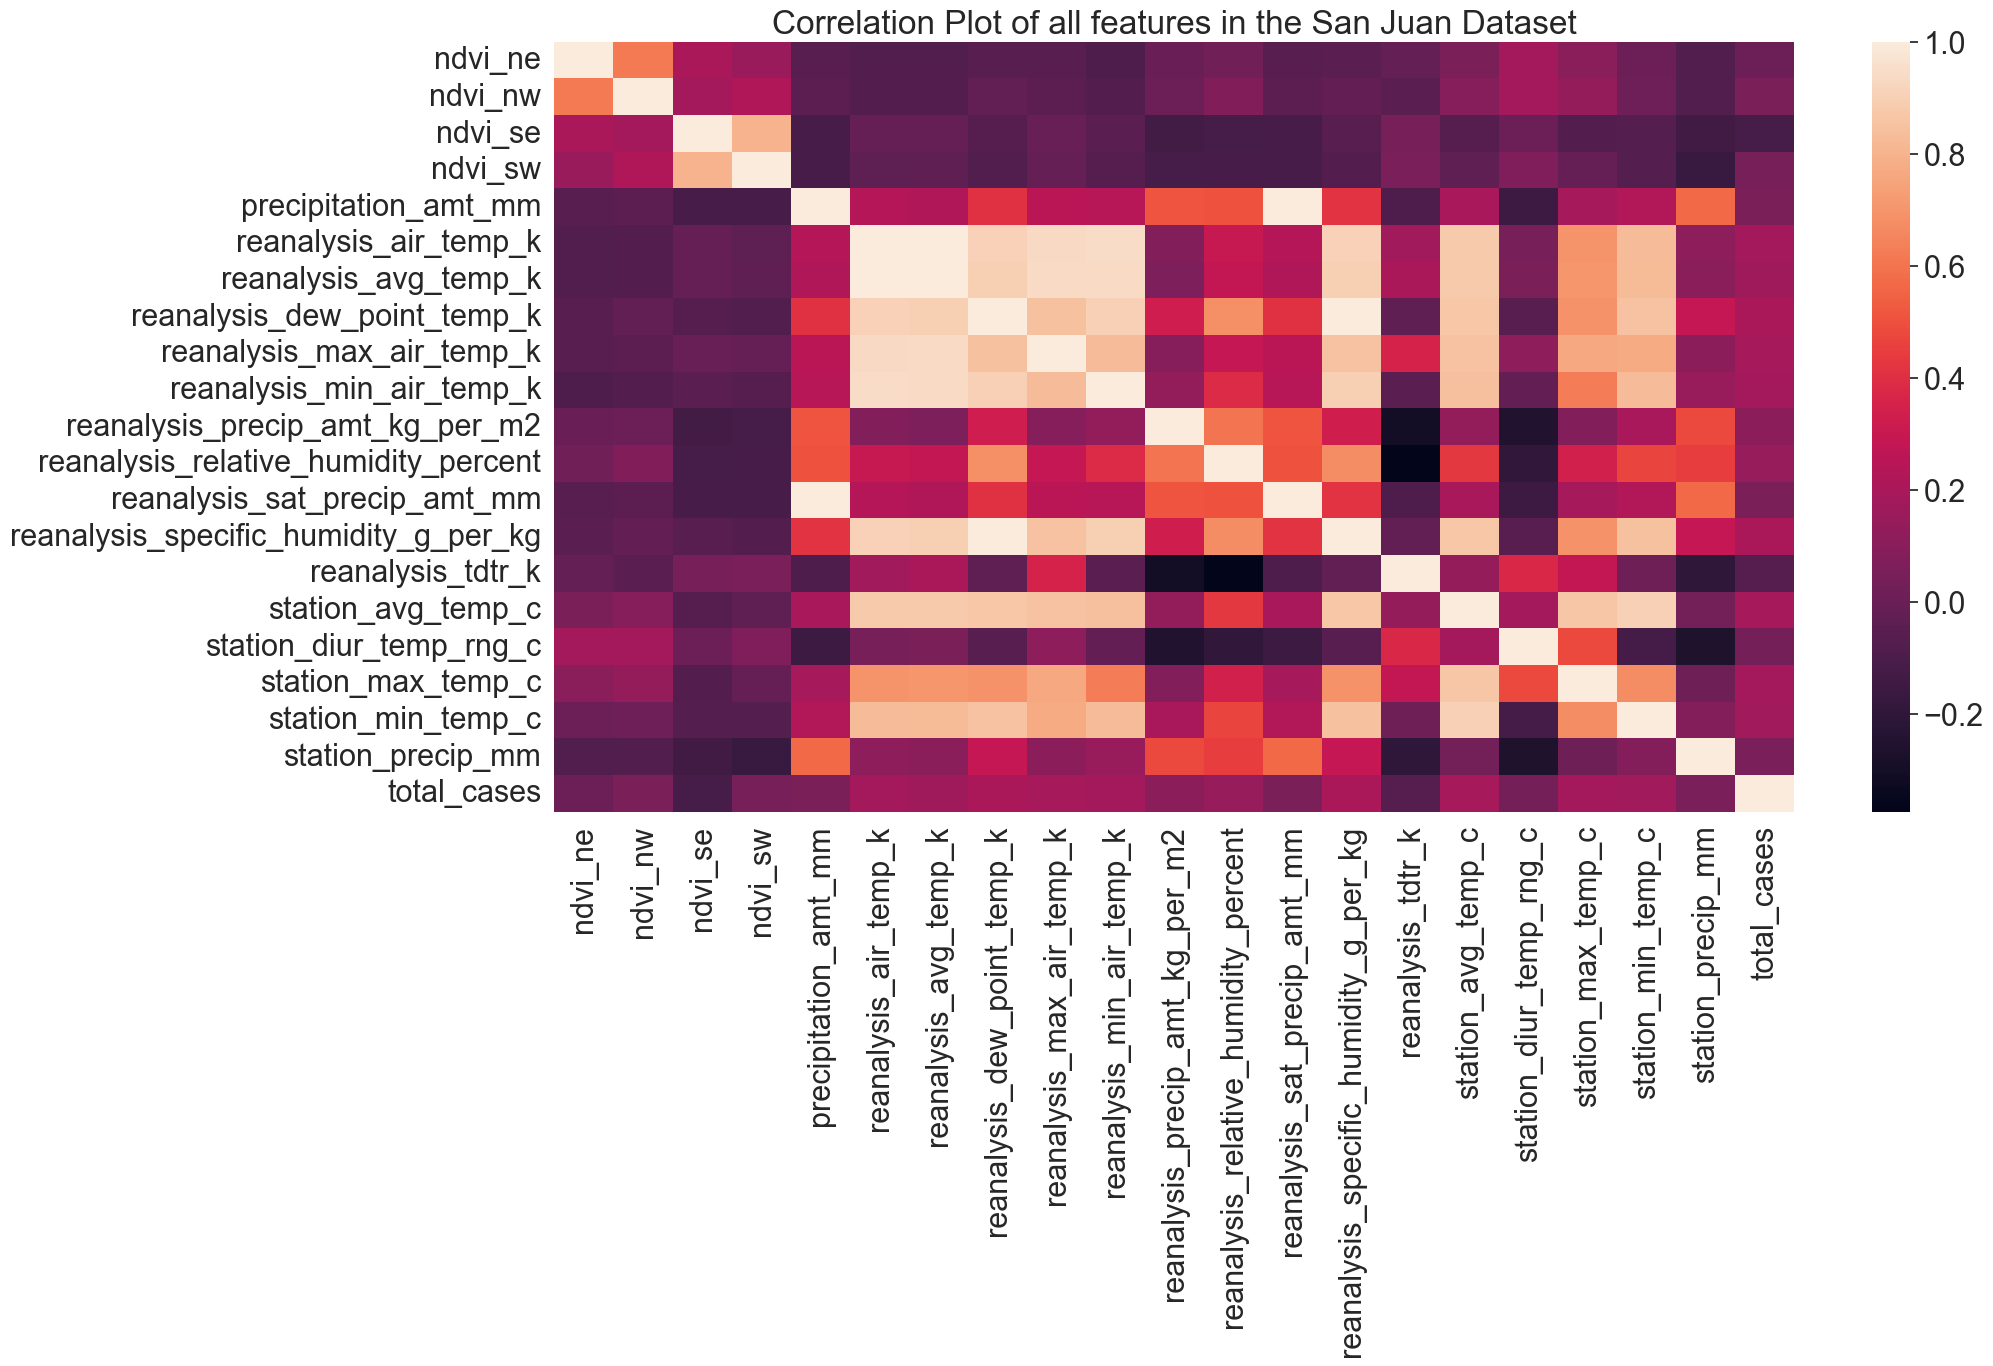

In [12]:
sj_x_train['total_cases'] = sj_y_train['total_cases']

sj_corr = sj_x_train.corr()

sns.set(font_scale = 2)
plt.figure(figsize=(20, 10))

sns.heatmap(sj_corr)
plt.title('Correlation Plot of all features in the San Juan Dataset')
plt.show()

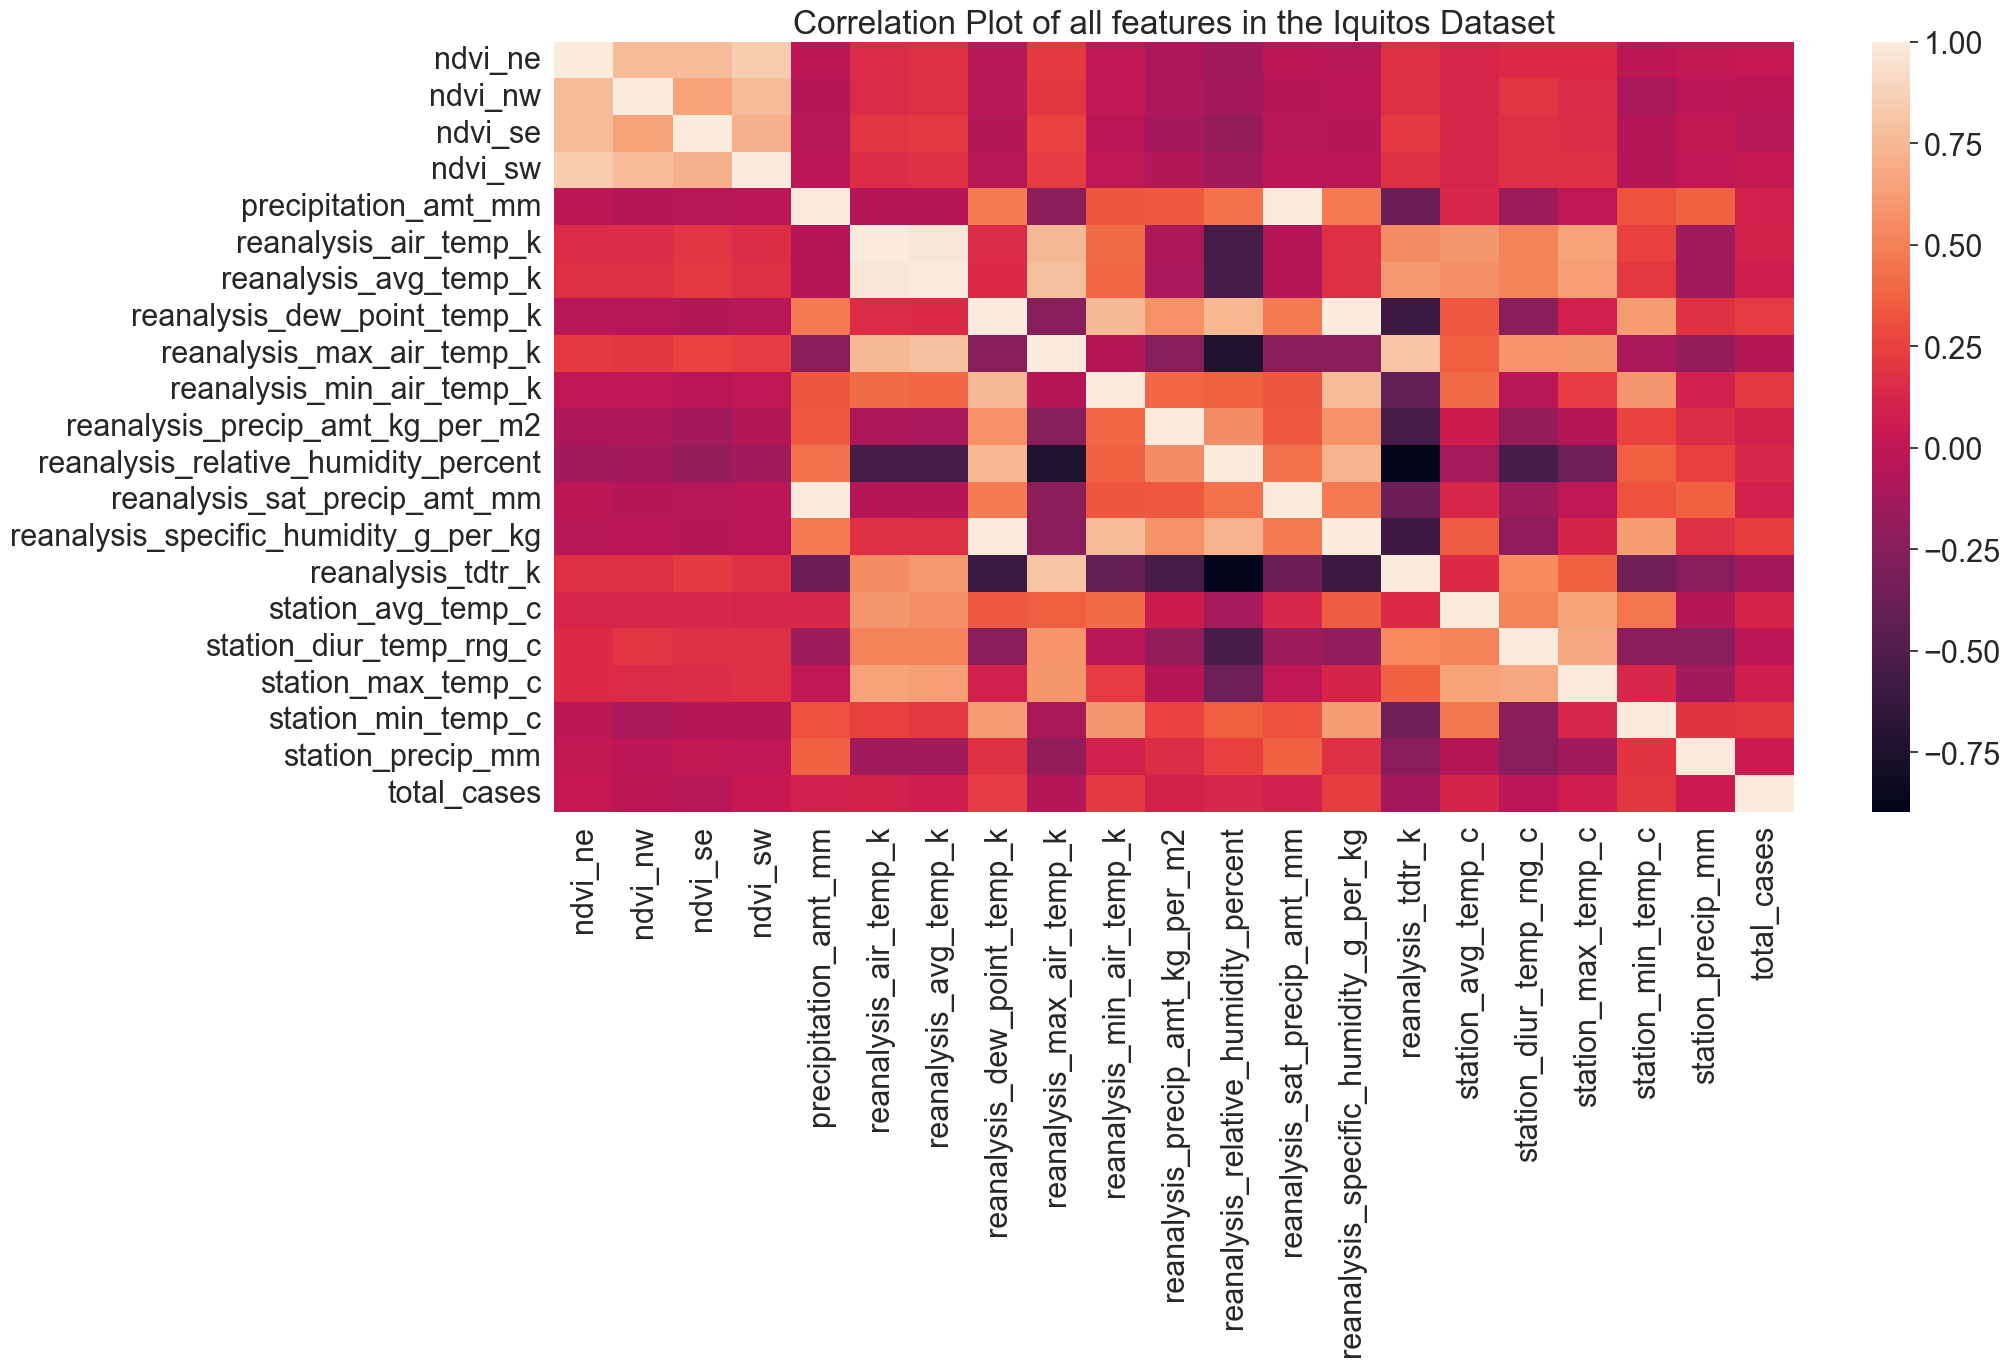

In [13]:
iq_x_train['total_cases'] = iq_y_train['total_cases']

iq_corr = iq_x_train.corr()

sns.set(font_scale = 2)
plt.figure(figsize=(20, 10))

sns.heatmap(iq_corr)
plt.title('Correlation Plot of all features in the Iquitos Dataset')
plt.show()

We can derive from the correlation heatmaps that the total_cases variable is not strongly correlated with any of the other variables in both datasets. Some of the other variables, however, are in fact strongly correlated with others, especially the temperature variables. 

### Sorted correlations (with total_cases)

<Axes: >

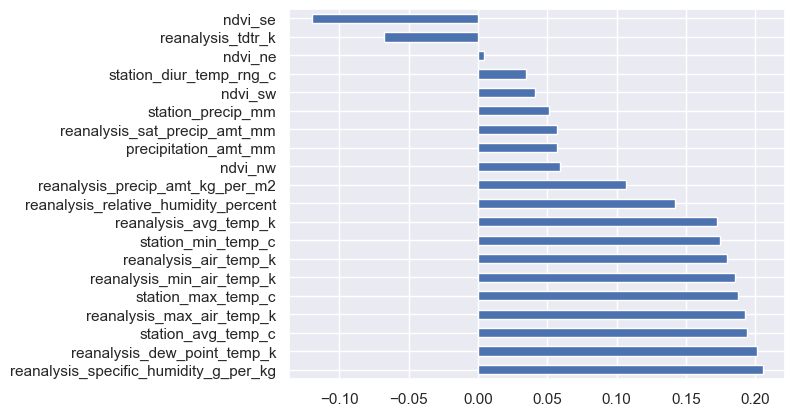

In [14]:
# San Juan
sns.set(font_scale = 1)
(sj_corr
     .total_cases
     .drop('total_cases') # don't compare with itself
     .sort_values(ascending=False)
     .plot
     .barh())

<Axes: >

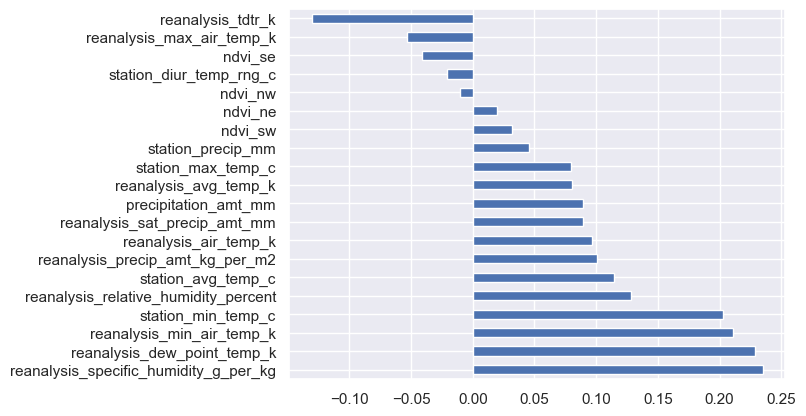

In [15]:
# Iquitos
sns.set(font_scale = 1)
(iq_corr
     .total_cases
     .drop('total_cases') # don't compare with itself
     .sort_values(ascending=False)
     .plot
     .barh())

'Reanalysis_specific_humidity_g_per_kg' and 'reanalysis_dew_point_temp_k' seem to be strongest correlated with 'total_cases', which makes sense as musquitos thrive in wet weather. However, surprisingly, precipitation does not seem to be very strongly correlated to 'total_cases'.

### Distribution of total_cases

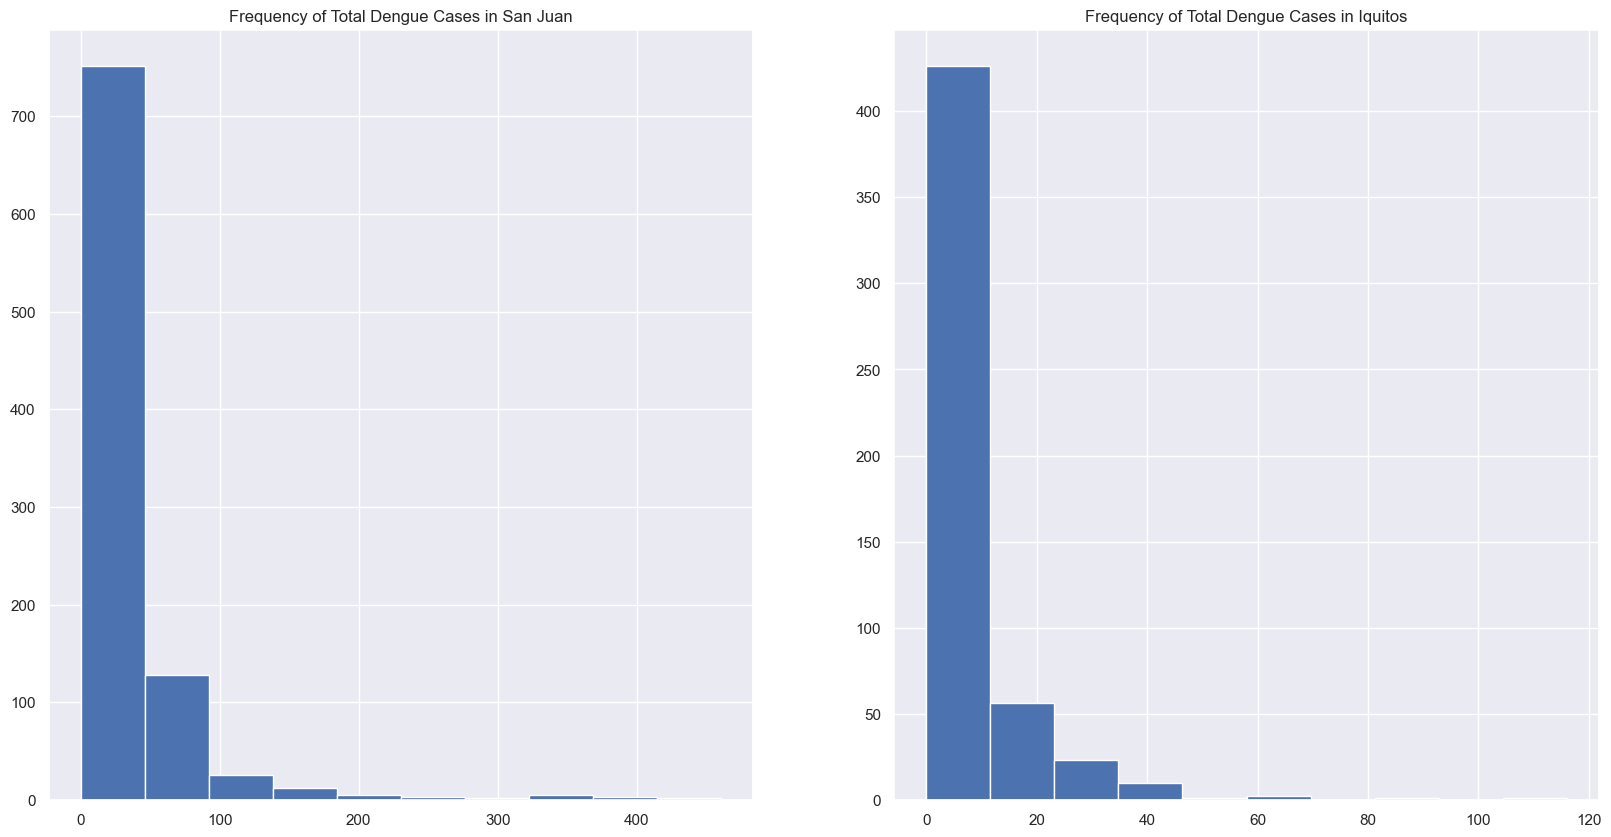

In [16]:
plt.figure(figsize = (20, 10))

plt.subplot(1, 2, 1)
plt.hist(sj_x_train['total_cases'])
plt.title('Frequency of Total Dengue Cases in San Juan')

plt.subplot(1, 2, 2)
plt.hist(iq_x_train['total_cases'])
plt.title('Frequency of Total Dengue Cases in Iquitos')

plt.show()

In [17]:
print('San Juan')
print('mean: ', sj_x_train['total_cases'].mean())
print('var :', sj_x_train['total_cases'].var())
print('Iquitos')    
print('mean: ', iq_x_train['total_cases'].mean())
print('var :', iq_x_train['total_cases'].var())

San Juan
mean:  34.18055555555556
var : 2640.0454396910277
Iquitos
mean:  7.565384615384615
var : 115.89552393656439


The total_cases variable seems to follow a negative binomial distribution, as the variance is much larger than the mean. Therefore, binomial regression seems to be the best fit for this data.

### Regression

First, we split the training and test data for each subset.

In [18]:
sj_x_train.drop('total_cases', axis = 1, inplace = True)
iq_x_train.drop('total_cases', axis = 1, inplace = True)

In [19]:
n_sj = len(sj_x_train)
split_idx_sj = int(n_sj * 0.8)

x_train_sj = sj_x_train.iloc[:split_idx_sj].reset_index(drop=True)
y_train_sj = sj_y_train.iloc[:split_idx_sj].reset_index(drop=True)
x_test_sj = sj_x_train.iloc[split_idx_sj:].reset_index(drop=True)
y_test_sj = sj_y_train.iloc[split_idx_sj:].reset_index(drop=True)

#Iquitos
n_iq = len(iq_x_train)
split_idx_iq = int(n_iq * 0.8)

x_train_iq = iq_x_train.iloc[:split_idx_iq].reset_index(drop=True)
y_train_iq = iq_y_train.iloc[:split_idx_iq].reset_index(drop=True)
x_test_iq = iq_x_train.iloc[split_idx_iq:].reset_index(drop=True)
y_test_iq = iq_y_train.iloc[split_idx_iq:].reset_index(drop=True)

print('X_train_sj:', x_train_sj.shape)
print('y_train_sj:', y_train_sj.shape)
print('X_test_sj:', x_test_sj.shape)
print('y_test_sj:', y_test_sj.shape)
print('X_train_iq:', x_train_iq.shape)
print('y_train_iq:', y_train_iq.shape)
print('X_test_iq:', x_test_iq.shape)
print('y_test_iq:', y_test_iq.shape)

X_train_sj: (748, 20)
y_train_sj: (748, 1)
X_test_sj: (188, 20)
y_test_sj: (188, 1)
X_train_iq: (416, 20)
y_train_iq: (416, 1)
X_test_iq: (104, 20)
y_test_iq: (104, 1)


In [20]:
print(x_train_sj.head())

    ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  precipitation_amt_mm  \
0  0.122600  0.103725  0.198483  0.177617                 12.42   
1  0.169900  0.142175  0.162357  0.155486                 22.82   
2  0.032250  0.172967  0.157200  0.170843                 34.54   
3  0.128633  0.245067  0.227557  0.235886                 15.36   
4  0.196200  0.262200  0.251200  0.247340                  7.52   

   reanalysis_air_temp_k  reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
0             297.572857             297.742857                   292.414286   
1             298.211429             298.442857                   293.951429   
2             298.781429             298.878571                   295.434286   
3             298.987143             299.228571                   295.310000   
4             299.518571             299.664286                   295.821429   

   reanalysis_max_air_temp_k  reanalysis_min_air_temp_k  \
0                      299.8                      295.9  

In [21]:
from sklearn.model_selection import TimeSeriesSplit

# For San Juan
tscv = TimeSeriesSplit(n_splits=5)
for train_indices, test_indices in tscv.split(sj_x_train):
    pass  # This will leave train_indices and test_indices as the last split

x_train_sj = sj_x_train.iloc[train_indices].reset_index(drop=True)
x_test_sj = sj_x_train.iloc[test_indices].reset_index(drop=True)
y_train_sj = sj_y_train.iloc[train_indices].reset_index(drop=True)
y_test_sj = sj_y_train.iloc[test_indices].reset_index(drop=True)

# For Iquitos
tscv = TimeSeriesSplit(n_splits=5)
for train_indices, test_indices in tscv.split(iq_x_train):
    pass

x_train_iq = iq_x_train.iloc[train_indices].reset_index(drop=True)
x_test_iq = iq_x_train.iloc[test_indices].reset_index(drop=True)
y_train_iq = iq_y_train.iloc[train_indices].reset_index(drop=True)
y_test_iq = iq_y_train.iloc[test_indices].reset_index(drop=True)

### Feature selection

In [22]:
# For San Juan
sj_corr_sorted = sj_corr['total_cases'].drop('total_cases').abs().sort_values(ascending=False)
sj_top_features = sj_corr_sorted.head(9).index.tolist()
print("San Juan top features:", sj_top_features)

# For Iquitos
iq_corr_sorted = iq_corr['total_cases'].drop('total_cases').abs().sort_values(ascending=False)
iq_top_features = iq_corr_sorted.head(4).index.tolist()
print("Iquitos top features:", iq_top_features)

# Prepare feature matrices for regression
x_sj_reg = sj_x_train[sj_top_features]
y_sj_reg = sj_y_train['total_cases']

x_iq_reg = iq_x_train[iq_top_features]
y_iq_reg = iq_y_train['total_cases']

San Juan top features: ['reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_k', 'station_avg_temp_c', 'reanalysis_max_air_temp_k', 'station_max_temp_c', 'reanalysis_min_air_temp_k', 'reanalysis_air_temp_k', 'station_min_temp_c', 'reanalysis_avg_temp_k']
Iquitos top features: ['reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_k', 'reanalysis_min_air_temp_k', 'station_min_temp_c']


In [23]:
def best_nb_model(X_train, y_train, X_val, y_val, alpha_grid=np.linspace(0.01, 2, 100)):
    best_alpha = None
    best_mae = float('inf')
    best_result = None

    X_train_const = sm.add_constant(X_train)
    X_val_const = sm.add_constant(X_val)

    for alpha in alpha_grid:
        model = sm.GLM(y_train, X_train_const, family=sm.families.NegativeBinomial(alpha=alpha))
        result = model.fit()
        preds = np.round(result.predict(X_val_const)).astype(int)
        preds = np.clip(preds, 0, None)  # No negative cases
        mae = mean_absolute_error(y_val, preds)
        if mae < best_mae:
            best_mae = mae
            best_alpha = alpha
            best_result = result

    print(f"Best alpha: {best_alpha}, Best MAE: {best_mae}")
    return best_result, best_alpha, best_mae


In [24]:
# San Juan
sj_model, sj_alpha, sj_mae = best_nb_model(
    x_train_sj[sj_top_features], y_train_sj['total_cases'],
    x_test_sj[sj_top_features], y_test_sj['total_cases']
)
print("San Juan Negative Binomial Regression Summary:")
print(sj_model.summary())

Best alpha: 0.17080808080808083, Best MAE: 23.685897435897434
San Juan Negative Binomial Regression Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:            total_cases   No. Observations:                  780
Model:                            GLM   Df Residuals:                      770
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4451.3
Date:                Thu, 05 Jun 2025   Deviance:                       3916.5
Time:                        10:57:30   Pearson chi2:                 6.74e+03
No. Iterations:                    12   Pseudo R-squ. (CS):             0.4642
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.

In [25]:
# Iquitos
iq_model, iq_alpha, iq_mae = best_nb_model(
    x_train_iq[iq_top_features], y_train_iq['total_cases'],
    x_test_iq[iq_top_features], y_test_iq['total_cases']
)
print("\nIquitos Negative Binomial Regression Summary:")
print(iq_model.summary())

Best alpha: 0.01, Best MAE: 5.6976744186046515

Iquitos Negative Binomial Regression Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:            total_cases   No. Observations:                  434
Model:                            GLM   Df Residuals:                      429
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2547.2
Date:                Thu, 05 Jun 2025   Deviance:                       3813.8
Time:                        10:57:30   Pearson chi2:                 5.51e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.6916
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
----------

In [26]:
from sklearn.neighbors import KNeighborsRegressor

def best_knn_model(X_train, y_train, X_val, y_val, k_grid=range(1, 21)):
    best_k = None
    best_mae = float('inf')
    best_model = None

    for k in k_grid:
        model = KNeighborsRegressor(n_neighbors=k)
        model.fit(X_train, y_train)
        preds = np.round(model.predict(X_val)).astype(int)
        preds = np.clip(preds, 0, None)
        mae = mean_absolute_error(y_val, preds)
        if mae < best_mae:
            best_mae = mae
            best_k = k
            best_model = model

    print(f"Best k: {best_k}, Best MAE: {best_mae}")
    return best_model, best_k, best_mae

In [27]:
# San Juan
sj_knn_model, sj_knn_k, sj_knn_mae = best_knn_model(
    x_train_sj[sj_top_features], y_train_sj['total_cases'],
    x_test_sj[sj_top_features], y_test_sj['total_cases']
)
print(f"San Juan KNN Regression: Best k = {sj_knn_k}, MAE = {sj_knn_mae}")


Best k: 18, Best MAE: 23.46153846153846
San Juan KNN Regression: Best k = 18, MAE = 23.46153846153846


In [28]:
# Iquitos
iq_knn_model, iq_knn_k, iq_knn_mae = best_knn_model(
    x_train_iq[iq_top_features], y_train_iq['total_cases'],
    x_test_iq[iq_top_features], y_test_iq['total_cases']
)
print(f"Iquitos KNN Regression: Best k = {iq_knn_k}, MAE = {iq_knn_mae}")

Best k: 20, Best MAE: 6.116279069767442
Iquitos KNN Regression: Best k = 20, MAE = 6.116279069767442


In [29]:
from sklearn.ensemble import GradientBoostingRegressor

def best_gb_model(X_train, y_train, X_val, y_val, n_estimators_grid=[50, 100, 200], learning_rate_grid=[0.01, 0.05, 0.1]):
    best_params = None
    best_mae = float('inf')
    best_model = None

    for n_estimators in n_estimators_grid:
        for learning_rate in learning_rate_grid:
            model = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
            model.fit(X_train, y_train)
            preds = np.round(model.predict(X_val)).astype(int)
            preds = np.clip(preds, 0, None)
            mae = mean_absolute_error(y_val, preds)
            if mae < best_mae:
                best_mae = mae
                best_params = (n_estimators, learning_rate)
                best_model = model

    print(f"Best Gradient Boosting params: n_estimators={best_params[0]}, learning_rate={best_params[1]}, MAE={best_mae}")
    return best_model, best_params, best_mae

In [30]:
# San Juan
sj_gb_model, sj_gb_params, sj_gb_mae = best_gb_model(
    x_train_sj[sj_top_features], y_train_sj['total_cases'],
    x_test_sj[sj_top_features], y_test_sj['total_cases']
)
print(f"San Juan Gradient Boosting: Best params = {sj_gb_params}, MAE = {sj_gb_mae}")


Best Gradient Boosting params: n_estimators=50, learning_rate=0.01, MAE=26.91025641025641
San Juan Gradient Boosting: Best params = (50, 0.01), MAE = 26.91025641025641


In [31]:
# Iquitos
iq_gb_model, iq_gb_params, iq_gb_mae = best_gb_model(
    x_train_iq[iq_top_features], y_train_iq['total_cases'],
    x_test_iq[iq_top_features], y_test_iq['total_cases']
)
print(f"Iquitos Gradient Boosting: Best params = {iq_gb_params}, MAE = {iq_gb_mae}")

Best Gradient Boosting params: n_estimators=50, learning_rate=0.01, MAE=5.651162790697675
Iquitos Gradient Boosting: Best params = (50, 0.01), MAE = 5.651162790697675


In [34]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb


# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 3, 5, 7, 9],
    'objective': ['count:poisson'],  # Poisson regression for count data
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'random_state': [42]
}

# San Juan
xgb_reg_sj = xgb.XGBRegressor(tree_method='hist', verbosity=0)
grid_sj = GridSearchCV(
    xgb_reg_sj,
    param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,
    n_jobs=-1
)
grid_sj.fit(x_train_sj[sj_top_features], y_train_sj['total_cases'])
print("San Juan XGBoost best params:", grid_sj.best_params_)
print("San Juan XGBoost best MAE:", -grid_sj.best_score_)

# Iquitos
xgb_reg_iq = xgb.XGBRegressor(tree_method='hist', verbosity=0)
grid_iq = GridSearchCV(
    xgb_reg_iq,
    param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,
    n_jobs=-1
)
grid_iq.fit(x_train_iq[iq_top_features], y_train_iq['total_cases'])
print("Iquitos XGBoost best params:", grid_iq.best_params_)
print("Iquitos XGBoost best MAE:", -grid_iq.best_score_)

# Predict on validation/test set
sj_pred = grid_sj.predict(x_test_sj[sj_top_features])
iq_pred = grid_iq.predict(x_test_iq[iq_top_features])

sj_pred = np.round(sj_pred).astype(int)
sj_pred = np.clip(sj_pred, 0, None)
iq_pred = np.round(iq_pred).astype(int)
iq_pred = np.clip(iq_pred, 0, None)

print("San Juan XGBoost MAE on test:", mean_absolute_error(y_test_sj['total_cases'], sj_pred))
print("Iquitos XGBoost MAE on test:", mean_absolute_error(y_test_iq['total_cases'], iq_pred))

San Juan XGBoost best params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 50, 'objective': 'count:poisson', 'random_state': 42, 'subsample': 0.8}
San Juan XGBoost best MAE: 31.80502700805664
Iquitos XGBoost best params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'objective': 'count:poisson', 'random_state': 42, 'subsample': 1.0}
Iquitos XGBoost best MAE: 6.701680024464925
San Juan XGBoost MAE on test: 26.82051282051282
Iquitos XGBoost MAE on test: 5.686046511627907


In [77]:
from sklearn.preprocessing import StandardScaler

# Scale features and target
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

X_train_scaled = feature_scaler.fit_transform(x_train_sj[sj_top_features])
X_test_scaled = feature_scaler.transform(x_test_sj[sj_top_features])

y_train_scaled = target_scaler.fit_transform(y_train_sj['total_cases'].values.reshape(-1, 1)).flatten()
y_test_scaled = target_scaler.transform(y_test_sj['total_cases'].values.reshape(-1, 1)).flatten()

def lagged_sequences_np(X, y, lags):
    Xs, ys = [], []
    for i in range(lags, len(X)):
        Xs.append(X[i-lags:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Use the last time step
        out = self.fc(out)
        return out

lags = 7
hidden_size = 16
num_layers = 1

X_train_seq, y_train_seq = lagged_sequences_np(X_train_scaled, y_train_scaled, lags)
X_test_seq, y_test_seq = lagged_sequences_np(X_test_scaled, y_test_scaled, lags)

X_train_torch = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_torch = torch.tensor(y_train_seq, dtype=torch.float32)
X_test_torch = torch.tensor(X_test_seq, dtype=torch.float32)
y_test_torch = torch.tensor(y_test_seq, dtype=torch.float32)

model = LSTMRegressor(
    input_size=X_train_torch.shape[2],
    hidden_size=hidden_size,
    num_layers=num_layers
)

criterion = nn.L1Loss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)
epochs = 30

mae_history = []
best_mae = float('inf')
best_epoch = 0
patience = 5  # You can adjust this
best_model_state = None

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_torch).squeeze()
    loss = criterion(output, y_train_torch.squeeze())
    loss.backward()
    optimizer.step()
    
    # Evaluate on test set at every epoch
    model.eval()
    with torch.no_grad():
        y_pred_scaled = model(X_test_torch).squeeze().numpy()
        y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
        y_true = target_scaler.inverse_transform(y_test_torch.squeeze().numpy().reshape(-1, 1)).flatten()
        y_pred = np.clip(y_pred, 0, None)
        mae = np.mean(np.abs(y_pred - y_true))
        mae_history.append(mae)
        
        # Early stopping check
        if mae < best_mae:
            best_mae = mae
            best_epoch = epoch
            best_model_state = model.state_dict()
        elif epoch - best_epoch >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best MAE: {best_mae:.4f}")
            break

    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Test MAE: {mae:.4f}")

# Restore best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Restored best model from epoch {best_epoch+1} with MAE: {best_mae:.4f}")

print("Final LSTM MAE on test set:", best_mae)

Epoch 5/30, Loss: 0.4660, Test MAE: 22.3597
Epoch 10/30, Loss: 0.4506, Test MAE: 21.2024
Epoch 15/30, Loss: 0.4351, Test MAE: 19.2740
Epoch 20/30, Loss: 0.4237, Test MAE: 19.4185
Epoch 25/30, Loss: 0.4143, Test MAE: 17.7866
Epoch 30/30, Loss: 0.4098, Test MAE: 18.1927
Restored best model from epoch 29 with MAE: 17.3218
Final LSTM MAE on test set: 17.321774


In [79]:
# Scale the test features using the same scaler as training
x_pred_sj = sj_x_test[sj_top_features].copy()
x_pred_sj_scaled = feature_scaler.transform(x_pred_sj)

lags = 7
def lagged_sequences_predict(X, lags):
    Xs = []
    for i in range(lags, len(X)):
        Xs.append(X[i-lags:i])
    return np.array(Xs)

# Use scaled features
x_pred_sj_seq = lagged_sequences_predict(x_pred_sj_scaled, lags)
X_pred_sj_torch = torch.tensor(x_pred_sj_seq, dtype=torch.float32)

model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_pred_sj_torch).squeeze().numpy()
    # Inverse transform to original scale
    y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_pred = np.round(y_pred).astype(int)
    y_pred = np.clip(y_pred, 0, None)
print(y_pred)

[15 16 19 21 22 25 22 27 22 24 25 26 28 32 34 38 34 35 38 37 30 24 25 27
 27 26 23 20 17 15 12 11 12 12 13 15 17 16 15 15 14 14 12 12 11  8  7 10
 10 15  9  8  9 10 16 20 26 28 29 29 31 32 31 35 37 36 40 41 39 39 37 37
 43 45 43 40 35 31 24 19 19 20 21 23 27 26 26 20 15 16 11 17 20 16 14 19
 20 19 13 10 14 13 13 19 22 23 26 31 27 27 28 27 22 25 28 31 29 34 36 37
 35 35 34 36 36 35 34 39 32 24 19 14 15 15 17 16 16 18 17 16 16 19 19 18
 16 15 15 10 11 13 12 13 16 15 14  7  8  3  0  5 12 17 20 22 24 20 18 20
 22 24 24 29 29 28 31 32 33 24 26 24 24 24 23 22 24 20 15 16 15 17 17 20
 18 20 17 15 16 15 18 16 13 14 15 13 18 14 16 17 12 16 19 29 35 39 41 41
 40 38 32 31 36 35 36 36 35 36 37 36 36 36 39 41 39 41 43 40 34 28 22 20
 18 17 17 16 13 12 10 13 12  8 12 10 11]


In [39]:
print("x_pred_sj shape:", x_pred_sj.shape)
print("x_pred_sj_seq shape:", x_pred_sj_seq.shape)
print("Variance per feature in x_pred_sj_seq:", np.std(x_pred_sj_seq, axis=(0,1)))

x_pred_sj shape: (260, 9)
x_pred_sj_seq shape: (240, 20, 9)
Variance per feature in x_pred_sj_seq: [1.0902608  1.06762666 1.04195689 1.10149142 1.03037528 1.0781111
 1.07840146 1.00156069 1.08376001]


In [40]:
print(sj_top_features)

['reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_k', 'station_avg_temp_c', 'reanalysis_max_air_temp_k', 'station_max_temp_c', 'reanalysis_min_air_temp_k', 'reanalysis_air_temp_k', 'station_min_temp_c', 'reanalysis_avg_temp_k']


In [41]:
# Calculate iq_top_features again using only the training set (to avoid data leakage)
correlations = x_train_iq.corrwith(y_train_iq)
iq_top_features = correlations.abs().sort_values(ascending=False).head(10).index.tolist()


lags = 20
hidden_size = 64
num_layers = 2

# Prepare lagged sequences for IQ
X_train_seq_iq, y_train_seq_iq = lagged_sequences(x_train_iq[iq_top_features], y_train_iq, lags)
X_test_seq_iq, y_test_seq_iq = lagged_sequences(x_test_iq[iq_top_features], y_test_iq, lags)

X_train_torch_iq = torch.tensor(X_train_seq_iq, dtype=torch.float32)
y_train_torch_iq = torch.tensor(y_train_seq_iq, dtype=torch.float32)
X_test_torch_iq = torch.tensor(X_test_seq_iq, dtype=torch.float32)
y_test_torch_iq = torch.tensor(y_test_seq_iq, dtype=torch.float32)

model_iq = LSTMRegressor(
    input_size=X_train_torch_iq.shape[2],
    hidden_size=hidden_size,
    num_layers=num_layers
)
criterion_iq = nn.L1Loss()
optimizer_iq = torch.optim.Adam(model_iq.parameters(), lr=0.001)

epochs = 40
mae_history_iq = []
raw_mae_history_iq = []

for epoch in range(epochs):
    model_iq.train()
    optimizer_iq.zero_grad()
    output_iq = model_iq(X_train_torch_iq).squeeze()
    loss_iq = criterion_iq(output_iq, y_train_torch_iq.squeeze())
    loss_iq.backward()
    optimizer_iq.step()
    
    # Evaluate on test set at every epoch
    model_iq.eval()
    with torch.no_grad():
        y_pred_iq = model_iq(X_test_torch_iq).squeeze().numpy()
        raw_mae_iq = np.mean(np.abs(y_pred_iq - y_test_torch_iq.squeeze().numpy()))  # Raw MAE
        raw_mae_history_iq.append(raw_mae_iq)

        y_pred_rounded_iq = np.round(y_pred_iq).astype(int)
        y_pred_clipped_iq = np.clip(y_pred_rounded_iq, 0, None)
        mae_iq = np.mean(np.abs(y_pred_clipped_iq - y_test_torch_iq.squeeze().numpy()))  # Final MAE
        mae_history_iq.append(mae_iq)
    
    if (epoch + 1) % 5 == 0:
        print(f"[IQ] Epoch {epoch+1}/{epochs}, Loss: {loss_iq.item():.4f}, Raw MAE: {raw_mae_iq:.4f}, Final MAE: {mae_iq:.4f}")

print("Final Iquitos LSTM Raw MAE on test set:", raw_mae_history_iq[-1])
print("Final Iquitos LSTM MAE on test set (rounded and clipped):", mae_history_iq[-1])

NameError: name 'lagged_sequences' is not defined